# Diffusion Auto Encoder

This is a implementation from [audio-diffusion-pytorch](https://github.com/archinetai/audio-diffusion-pytorch). 

In [14]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
from pathlib import Path
import datetime

from audio_diffusion_pytorch import UNetV0, VDiffusion, VSampler
from audio_encoders_pytorch import MelE1d, TanhBottleneck

from src.datasets import MusicCapsDataset
from src.features import PreProcessor
from src.features.extractor import WaveformExtractor
from src.utils.data import TorchDataset

from pytorch_lightning.callbacks import Callback
import copy
import torch.optim as optim
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from audio_diffusion_pytorch import DiffusionAE as DiffusionAEBase
import matplotlib.pyplot as plt

## Data Preparation

### Generate Dataset

Each Musiccaps dataset has 10-second audios. To adapt to this model we will apply the following changes to the data:

* We will divide the data into two parts of 5.5 seconds. Each part of the audio will have two times: from 0 to 5.5 and 4.5 to 10 seconds.
* For each new audio, we will add information to the 'aspect list' and 'caption' explaining the audio track. For example '1 of 2' or '2 of 2'.

In [2]:
musiccaps_generator = MusicCapsDataset(format="mp3", crop_length=5.5)
dataset = musiccaps_generator.generate(num_proc=1)

### Preprocessing the data

For the format defined by the article, we need to cut the song to size 2**18 (approximately 5.5 seconds), so that it adapts to the network input

In [3]:
# Tip: We don't need to save waveforms.
train, test = PreProcessor(dataset, lambda dataset : WaveformExtractor(dataset, column="audio", crop_length=2**18)).get_train_test_split(path=musiccaps_generator.get_processed_folder(), save_split_sets=False)

Loading train/test indexes...


Generating test subset [Waveform]: 100%|██████████| 2178/2178 [02:06<00:00, 17.26it/s]


## Training

### Adapting train data

We need to adapt the standard pytorch data:

* The pattern suggested in the documentation is [batch, in_channels, length]. In our case, our dataset is in the format [batch, length]. (length is the multiplication of frequency by time).
* We need to use DataLoader, an optimized implementation to access our data.
* We take the opportunity to use the gpu, if available

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 4
transform = lambda x: x.unsqueeze(0) # (batch, length) ->  (batch, 1, length)

train_dataset = TorchDataset(train[:20], transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### Model definition

We use the same as the original example. We add an optimizer to update the parameters of the model based on the gradients computed during backpropagation.
The loss is calculated internally.

### Training loop

In [6]:
MODEL_ROOT_FOLDER = "models"

class DiffusionAE(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = DiffusionAEBase(
                    encoder=MelE1d(
                        in_channels=1,
                        channels=512,
                        multipliers=[1, 1],
                        factors=[2],
                        num_blocks=[12],
                        out_channels=32,
                        mel_channels=80,
                        mel_sample_rate=48000,
                        mel_normalize_log=True,
                        bottleneck=TanhBottleneck(),
                    ),
                    inject_depth=6,
                    net_t=UNetV0,
                    in_channels=1,
                    channels=[8, 32, 64, 128, 256, 512, 512, 1024, 1024],
                    factors=[1, 4, 4, 4, 2, 2, 2, 2, 2],
                    items=[1, 2, 2, 2, 2, 2, 2, 4, 4],
                    diffusion_t=VDiffusion,
                    sampler_t=VSampler,
                    )
        self.model_dir = f"{MODEL_ROOT_FOLDER}/DiffusionAE"

    def configure_optimizers(self):
        optimizer = optim.Adam(self.model.parameters(), lr=1e-4)
        return optimizer

    def training_step(self, batch, batch_idx):
        loss = self.model(batch)
        self.log('train_loss', loss)
        return loss
    
    def get_model_folder(self):
        """
        Returns the path to the model folder for saving checkpoints.

        Returns:
            str: The path to the raw folder.
        """
        Path(self.model_dir).mkdir(exist_ok=True, parents=True)
        return self.model_dir

    def configure_logger(self):
        return pl.loggers.TensorBoardLogger(self.log_dir)

In [8]:
class MetricsCallback(Callback):
    """A PyTorch Lightning callback that logs the metrics at the end of each train epoch.

    This callback logs the metrics computed by the trainer at the end of each train epoch and stores them in a
    list. The logged metrics can be accessed through the `metrics` attribute of the callback.

    Args:
        metrics (list[dict[str, float]]): A list of dictionaries containing the logged metrics at the end of each
            train epoch. Each dictionary contains the metric names as keys and their values as values.

    """
    def __init__(self):
        super().__init__()
        self.metrics = []

    def on_train_epoch_end(self, trainer, pl_module):
        """Log the metrics at the end of each train epoch.

        This method is called by the trainer at the end of each train epoch. It logs the metrics computed by
        the trainer and stores them in a list.

        Args:
            trainer (Trainer): The trainer instance.
            pl_module (LightningModule): The LightningModule instance being trained.
            
        """
        self.metrics.append(copy.deepcopy(trainer.callback_metrics))

In [9]:
# Define o modelo autoencoder e os dataloaders
autoencoder = DiffusionAE()

# Diretório para salvar os checkpoints
save_dir = autoencoder.get_model_folder()
current_time = datetime.datetime.now().strftime("/run_%Y-%m-%d_%H-%M-%S'")
Path(save_dir + current_time).mkdir(exist_ok=True, parents=True)

callbacks_list = [ModelCheckpoint(dirpath=save_dir + current_time, save_top_k=-1, verbose=True),
                  MetricsCallback()]

# Configurar treinamento
trainer = pl.Trainer(
    max_epochs=5,  # Número de épocas
    callbacks=callbacks_list,
)

# Treinar o modelo
trainer.fit(model=autoencoder, train_dataloaders=train_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: d:\Users\neliareis\Documents\workspace\Python\text-to-music\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | DiffusionAE | 197 M 
--------------------------------------
197 M     Trainable params
0         Non-trainable params
197 M     Total params
790.878   Total estimated model params size (MB)
d:\Users\neliareis\Documents\workspace\Python\text-to-music\.conda\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
d:\Users\neliareis\Documents\workspace\Python\text-to-music\.conda\Lib\site-packages\p

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [15]:
logged_metrics = callbacks_list[1].metrics
losses_values = []

# Exiba as métricas
for metric_dict in logged_metrics:
    print("Metrics at the end of a validation epoch:")
    for metric_name, metric_value in metric_dict.items():
        print(f"{metric_name}: {metric_value}")
        losses_values.append(metric_value.cpu())

Metrics at the end of a validation epoch:
train_loss: 0.22691816091537476
Metrics at the end of a validation epoch:
train_loss: 0.2503470778465271
Metrics at the end of a validation epoch:
train_loss: 0.32330557703971863
Metrics at the end of a validation epoch:
train_loss: 0.2494998276233673
Metrics at the end of a validation epoch:
train_loss: 0.43762171268463135


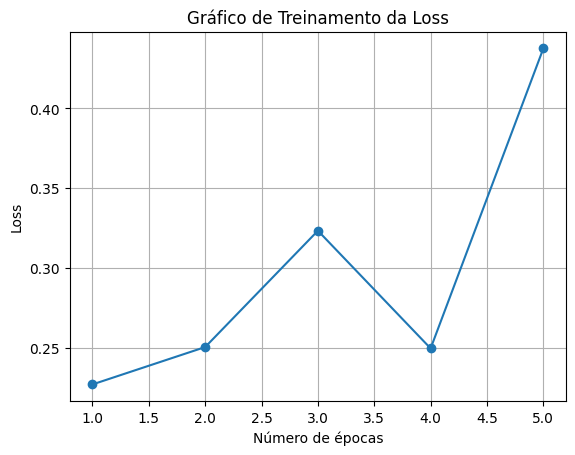

In [16]:
# Cria o gráfico da loss
plt.plot(range(1, len(losses_values) + 1), losses_values, marker='o')
plt.xlabel('Número de épocas')
plt.ylabel('Loss')
plt.title('Gráfico de Treinamento da Loss')
plt.grid()
plt.show()